In [3]:
## Importing relevant libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
import os as os 
warnings.filterwarnings("ignore")
from sklearn import metrics 
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier
from xgboost import  XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import joblib
from sklearn.metrics import accuracy_score
import PersonalStatModel as psm
from sklearn.preprocessing import LabelEncoder


Initial Cleaning and Transformation

In [4]:
## Loading data and inital transformation/cleaning of variables 
data = pd.read_excel("Churn.xlsx")
pd.options.display.max_columns=30
pd.options.display.max_rows=50

nulls = np.where(pd.isnull(data))
print(nulls)


##Initial Cleaning and Transformation
data['TotalCharges'] = data['TotalCharges'].replace(' ', np.nan) 
data['TotalCharges'] = data['TotalCharges'].replace(np.nan, data['TotalCharges'].mean()) 
data['TotalCharges'] = data['TotalCharges'].astype(float)

## Transforming the last string variable 


encoder = LabelEncoder()
df = data.copy(deep=True)

df['PaymentMethod'] = encoder.fit_transform(df['PaymentMethod'])
print(df['PaymentMethod'].unique(), '=', encoder.inverse_transform(df['PaymentMethod'].unique()))

df = df.drop(['Electronic Check',
       'Mailed Check', 'Credit Card', 'Bank Transfer', 'customerID'], axis=1)
df = df.drop(['Fiber Optic'], axis=1)
x = df.iloc[:,:-1]
y = df.iloc[:,-1:]

print(df.dtypes)

(array([], dtype=int64), array([], dtype=int64))
[2 3 0 1] = ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
gender                int64
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure                int64
PhoneService          int64
MultipleLines         int64
DSL                   int64
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract              int64
PaperlessBilling      int64
PaymentMethod         int32
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object


In [5]:
## Splitting continuous and categorical variables 
nr_categories = 3
columns = df.columns.values
cat_vars = []
num_vars = []
for i in columns:
    if len(df[i].unique()) > nr_categories:
        num_vars.append(i)
    if len(df[i].unique()) < nr_categories:
        cat_vars.append(i)
cat_vars.remove('Churn')



EDA

In [6]:
## Now we will move on to some multivariate EDA. Since the building and evaluation of a model has a big black box aspect
## Manual Multivariate EDA can still lead to valuable insights relating to the Telco Business 
## For this I will use my own module, written specifically to ease plotting, 

## This dataset has the following variable pairs: 
## Pairplots: Numerical vs Numerical Features               -> Whats the relationship between tenure and cost?
## Countplots, with hue: Categorical vs. Categorical        -> In which groups are big differences relating to churn?
## Boxplots, pairplot with hue: Categorical vs. Numerical   -> What are the average tenures and costs in different groups?

## First we look at countplots between DV and IV, checking for significant differences, we then zoom in on these groups looking at IV-IV relations


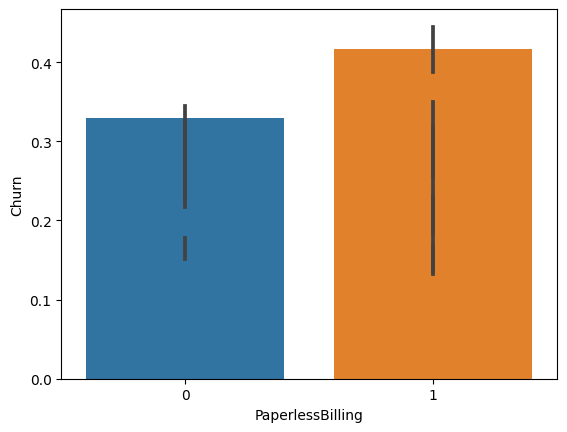

In [10]:
## Here I plot the categorical vs the categorical and the dv
for i in cat_vars: 
    plott = sns.barplot(df, x = i, y='Churn')
    plott.figure.savefig('eda' + i + '.png')

In [ ]:
## Looking at the plots I note the following things: 
## Churn is higer in Seniors, non Partnered, no dependents, using Fiber Optics, Not having Online Security, 
## Not having tech support, 1 month contracts, electronic check, 
## Some differences could be obvious such as seniors churning because of death, second: care services such as tech support and online security 
# Could be keeping people with the company. People churning from their 1 month contract could be: unhappy or going for a next discount
# This gives me three things to look into: why are seniors churning, how is the churning rate in each service, whats the churn distribution per contract


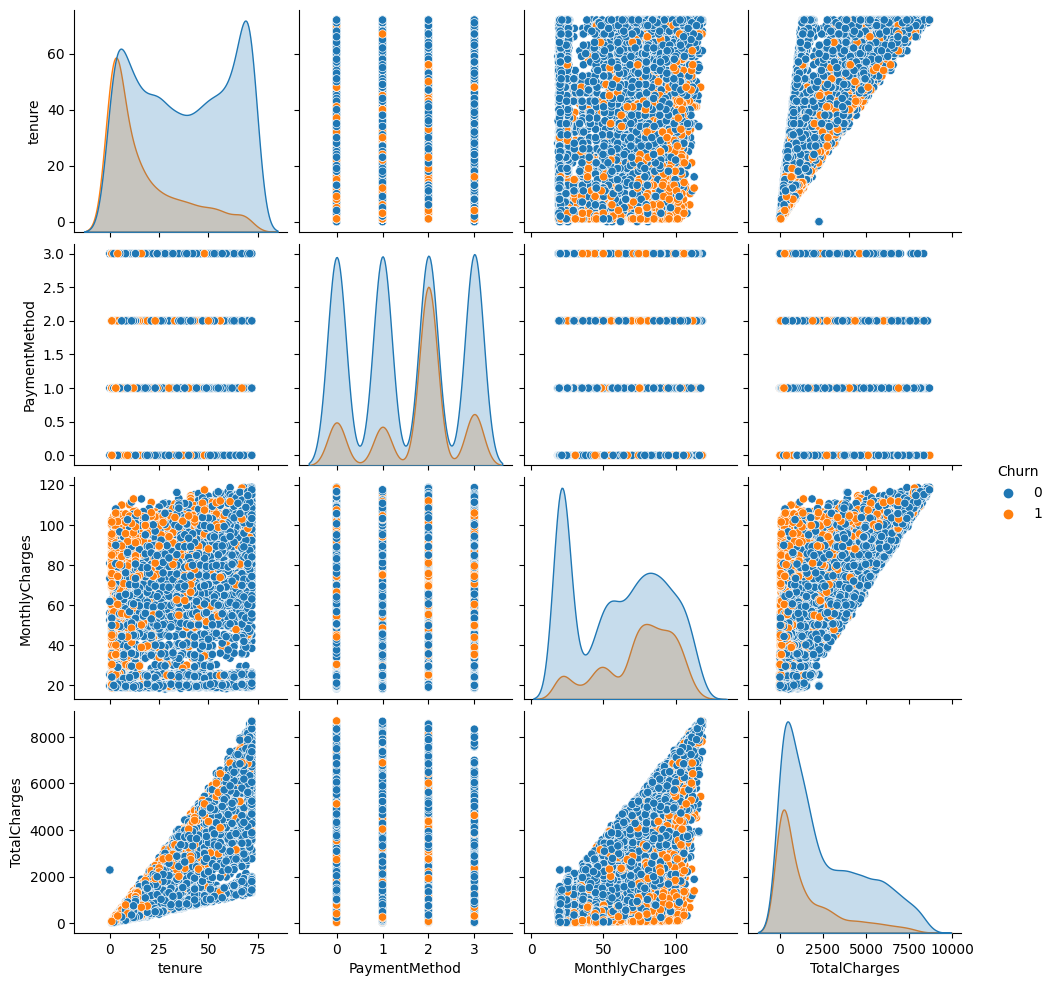

In [ ]:
## Here I plot the Numerical vs the Numerical vs the DV using pair plots as well as a binning method to enhance interpretability
num_df = df[num_vars]
num_df = pd.concat([num_df, df['Churn']], axis=1)
sns.pairplot(num_df, hue='Churn')

In [ ]:
## Binning 
bin_monthly = int(5)
bin_total = int(500)
bin_tenure = int(5)
df_bins = pd.DataFrame()
df_bins['Monthly'] = [int(i / bin_monthly) for i in df['MonthlyCharges']]
df_bins['Total'] = [int(i / bin_total) for i in df['TotalCharges']]
df_bins['Tenure'] = [int(i / bin_tenure) for i in df['tenure']]

df_binned = pd.concat([df, df_bins], axis=1)
df_binned = df_binned.drop(['MonthlyCharges', 'TotalCharges'], axis=1)

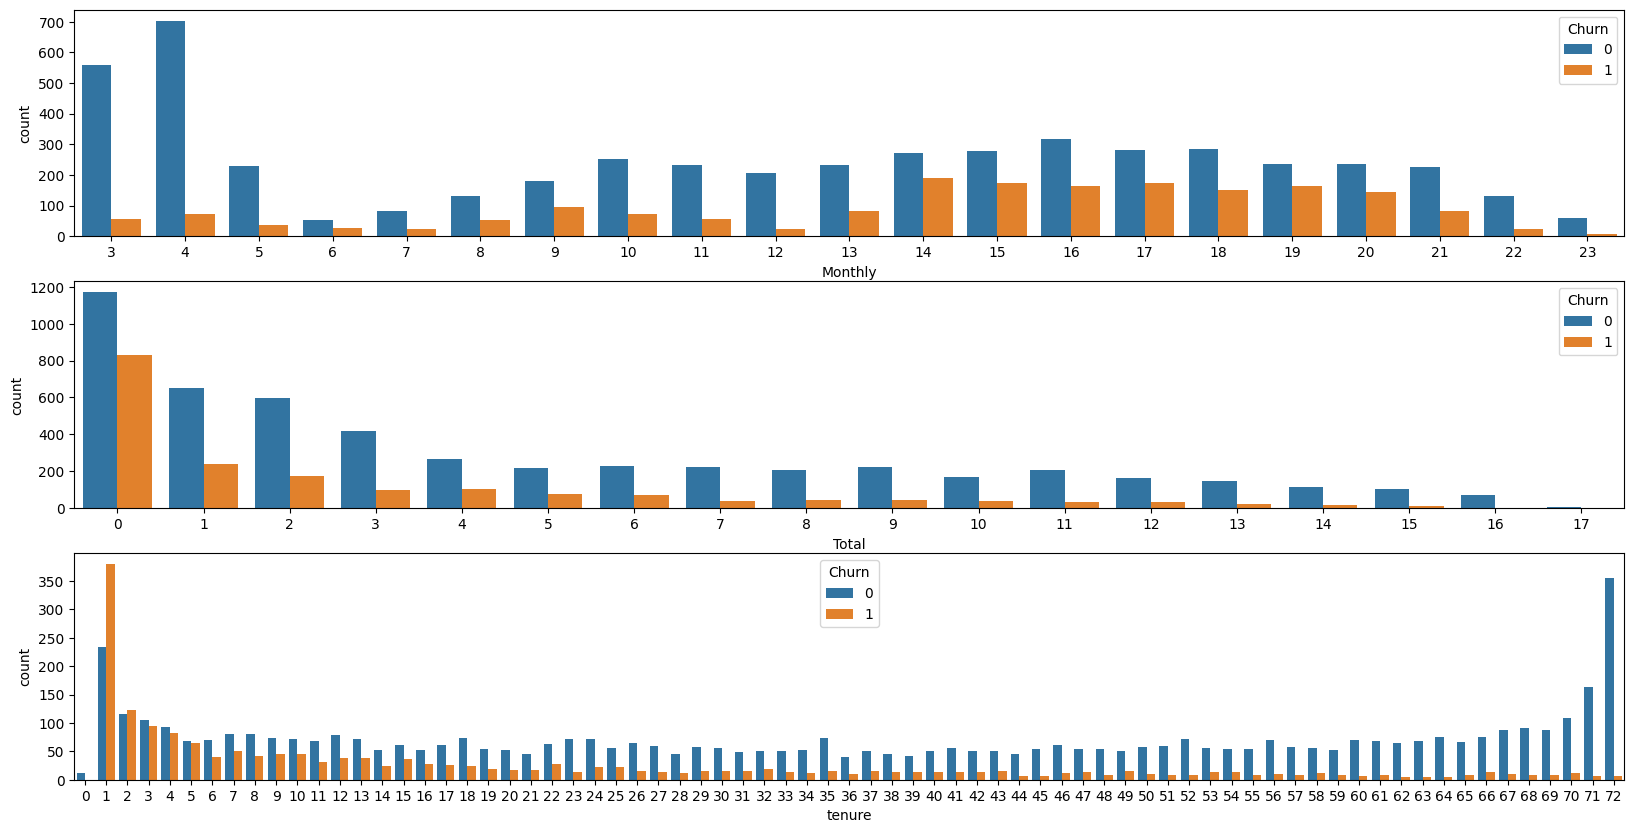

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,10))

folder = 'Num_Num'
if not os.path.exists(folder):                                             # Make a new folder to save the figs
    os.mkdir(folder)

plt.subplot(3, 1, 1)
sns.countplot( x = df_bins['Monthly'],hue=df['Churn'])
plt.subplot(3, 1, 2)
sns.countplot( x = df_bins['Total'],hue=df['Churn'])
plt.subplot(3,1,3)
sns.countplot(x=df['tenure'], hue=df['Churn'])
fig.savefig(folder + '/' + 'fig.png')

In [ ]:
## Categorical vs Numerical vs DV 
## Here we use boxplots instead of pairplots with hues simply because this takes a really long time to render
import os as os 
num_vars_plot = ['Monthly', 'Total', 'tenure', 'Contract']
cat_vars_plot = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'DSL', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies',  'PaperlessBilling', 'PaymentMethod',
       'Churn']
folder = 'Cat_Num_DV_PP'
if not os.path.exists(folder):                                             # Make a new folder to save the figs
    os.mkdir(folder)


for i in range(0,len(cat_vars_plot)):
    cat = cat_vars_plot[i]   
    for j in range(0,len(num_vars_plot)):
        num = num_vars_plot[j]
        plt.figure(figsize=(10,10))
        plot = sns.boxplot(x=cat, y=num, data=df_binned, hue='Churn')
        plot.figure.savefig(folder + '/' + cat + 'vs' + num + '.png')
        plt.close()                         

## Use this if you dont want to save anything local and show it here 
"""
for i in range(0,len(cat_vars_plot)):
    cat = cat_vars_plot[i]   
    for j in range(0,len(num_vars_plot)):
        num = num_vars_plot[j]
        plt.figure(figsize=(10,10))
        sns.boxplot(x=cat, y=num, data=df, hue='Churn')
"""
                                              

        

"\nfor i in range(0,len(cat_vars_plot)):\n    cat = cat_vars_plot[i]   \n    for j in range(0,len(num_vars_plot)):\n        num = num_vars_plot[j]\n        plt.figure(figsize=(10,10))\n        sns.boxplot(x=cat, y=num, data=df, hue='Churn')\n"

EDA Rapport 

In [ ]:
# Looking at the services of Telco there are some significant differences among the churners and loyal customers: Churn is higher among fiber optic users
    # and churn is a lot lower in Tech Support users. Generally most services dont have much difference in churn. That said, Tech Support and Fiber Optic
    # Seem to be important in the Churn dynamic. 
# Looking deeper into the service usage, generally Tenure is more spread out when people are using atleast one service, although churn does not impact this relationship
    # This means that people who use a service tend to stay longer at a company. This is most pronounced among people using the Online Backup Service.
# In order I would then advice Telco to take a look at the performance of their Fiber Optic Service as it seems this service is not up to expectations
    # since service usage generally leads to higher Tenure, this is reversed for Fiber Optic pointing to a service problem. 
# Second, for almost all services there is a increase in Churning when reaching a certain threshold for monthly costs except for Online Backup and Device Protection.
    # Looking at Online Backup the tenure is significantly higher than non users, also with respect to the relationship between tenure and service usage. 
    # This indicates that Online Backup users are more incentivized to stay with the company. 
# In order I would then advice Telco to use the Online Backup service as a means to tie people to the company, for example giving a free trial with a Monthly Contract


Checking Assumptions

In [ ]:
import PersonalStatModel as psm
## Check the specs of our data set
## A lot of multi collinearity, not too many outliers and the numerical features are not linear to the y log
## This means our data needs to be transformed to make a simple logistic model fit. 
## The multicollinearity is a problem for most models and as such needs to be dealt with
## Our Y classes are also very imbalanced so we need to use some sampling technique as most models are not good at dealing with imbalance. 
psm.assumption_check(x, y, num_vars, cat_vars)

##############################################Outliers########################################################
Cooks Threshold:    0.0006 Proportion Outlier: 4.984%
Residual Threshold: 3 Proportion Outlier: 1.207%
##############################################VIF########################################################
Variables with a high VIF            feature        VIF
4           tenure  15.541650
5     PhoneService  12.177304
17  MonthlyCharges  28.303213
18    TotalCharges  17.032885
##############################################Linearity########################################################
Variables with a non-linear relationship to log-odds(Y) for P Value: 0.05:
tenure:_logtenure                  7.362674e-08
PaymentMethod:_logPaymentMethod    3.366805e-06
TotalCharges:_logTotalCharges      4.449406e-02
dtype: float64
##############################################Sample Size########################################################
Total Sample Size:                 7043
Tota

In [ ]:
## Getting the specific outliers in order to remove them
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
from scipy import stats
logit_model = GLM(y, x, family = families.Binomial())
model_results = logit_model.fit()
         
## Getting influence measures 
influence = model_results.get_influence()
df_influence =  influence.summary_frame()
## Creating a summary df 
outlier_influence, outlier_influence['std_residuals'] = df_influence.loc[:,['cooks_d']], stats.zscore(model_results.resid_pearson).apply(lambda x: np.abs(x))
## Setting thresholds for plotting and sorting 
cd_outliers = outlier_influence[outlier_influence['cooks_d'] > 0.0006]
cd_outlier_prop =  len(cd_outliers) / len(x) * 100

## Check the outliers 
index_to_drop = list(cd_outliers.index)
df_outliers = x.loc[index_to_drop]


df_no_outliers = df.drop(index_to_drop)
x = df_no_outliers.iloc[:,:-1]
y = df_no_outliers.iloc[:,-1:]


Cleaning and Transformation

In [ ]:
## Scaling and resampling
# Since this dataset is very unbalanced I will use SMOTE to oversample the smaller class. 
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler()
x_scaled = x.copy()
x_scaled[['MonthlyCharges', 'TotalCharges', 'tenure']] = scale.fit_transform(x[['MonthlyCharges', 'TotalCharges', 'tenure']])


In [ ]:
##Resampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split

sc_x_train, sc_x_test, sc_y_train, sc_y_test = train_test_split(x_scaled,y,test_size=0.2)
smote = SMOTE()
sc_smote_x_train, sc_smote_y_train =    smote.fit_resample(sc_x_train, sc_y_train)

Feature Selection

In [ ]:
# In order to get the best results I only use the features with the most explanatory power. This is checked through ANOVA (continuous) and CHI2 (Categorical)
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,mutual_info_classif
from sklearn.feature_selection import f_classif
features = x[cat_vars]
best_cat_vars = SelectKBest(score_func=chi2, k='all')
fit = best_cat_vars.fit(features, y)


<Axes: >

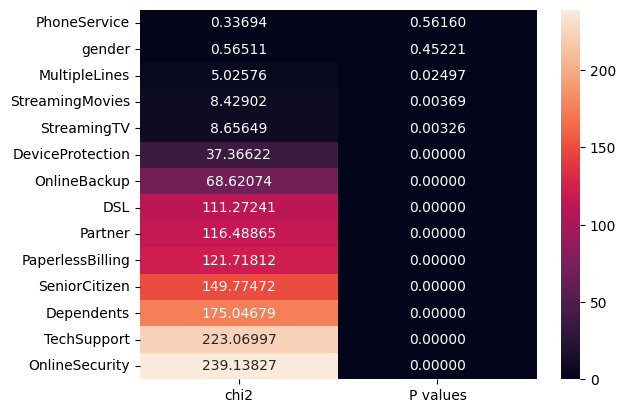

In [ ]:
feature_scores = pd.DataFrame(fit.scores_, index=list(features.columns), columns = ['chi2'])
ps = pd.concat([feature_scores, pd.DataFrame(fit.pvalues_, index=list(features.columns), columns=['P values'])], axis=1)
sns.heatmap(ps.sort_values(ascending=False, by='P values'), annot=True, fmt='.5f')

In [ ]:
x_featured = x_scaled.drop(['PhoneService', 'gender', 'MultipleLines'], axis=1)


<Axes: >

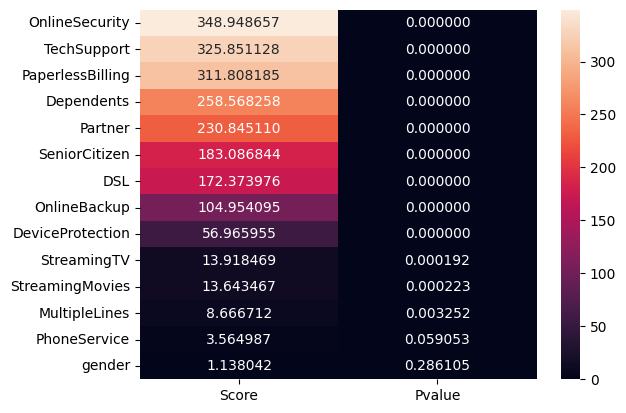

In [ ]:
best_features = SelectKBest(score_func=f_classif, k='all')
fit = best_features.fit(features, y)

feature_scores = pd.concat([pd.DataFrame(data=fit.scores_, index=list(features.columns), columns=['Score']), 
                                         pd.DataFrame(data=fit.pvalues_, index=list(features.columns), columns=['Pvalue'])], axis=1)

sns.heatmap(feature_scores.sort_values(by='Score', ascending=False), annot=True, fmt = '5f')

Model Building and Tuning

In [ ]:
## Testing the XGBoost, Random Forest, Decision Tree Classifiers 

model_list = [XGBClassifier(), RandomForestClassifier(), DecisionTreeClassifier()]

def build_evaluate(model_list, x, y):         
    from sklearn.model_selection import RepeatedStratifiedKFold     
    from sklearn.model_selection import cross_validate
    names = []
    results_df = pd.DataFrame()
    cv = RepeatedStratifiedKFold()
    for model in model_list:
        scores = cross_validate(model, x, y, scoring=['accuracy', 'roc_auc', 'f1'], return_train_score=True, cv=cv)
        scoring = {'mean accuracy': scores['test_accuracy'].mean(), 
                   'mean roc_auc': scores['test_roc_auc'].mean(),
                   'mean f1': scores['test_f1'].mean()}
        names.append(model)
        score_df = pd.DataFrame.from_dict(scoring, orient='index', columns=names)
        results_df = pd.concat([results_df, score_df], axis=1)
        names = []
    return results_df

In [ ]:
build_evaluate(model_list, x, y)

,"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n multi_strategy=None, n_estimators=None, n_jobs=None,\n num_parallel_tree=None, random_state=None, ...)",RandomForestClassifier(),DecisionTreeClassifier()
mean accuracy,0.829999,0.830639,0.793196
mean roc_auc,0.896651,0.895009,0.713174
mean f1,0.623417,0.609045,0.556346


In [ ]:
model = XGBClassifier()

In [ ]:
## For this part, we will be using the Bayes algo, this incorporates a 'informed method' -> using prior knowledge of which values work
# and which dont work. 

## For this experiment I will be optimizing the RandomForest using BayessearchCV 


## This is the actual 'space'. Meaning this algo will try different combinations of values for n_estimators, max depth and criterion. Right now this
# can be visualized as a 3D hyper plane, since we are using 3 variables (1 var for each axis (x,y,z)).
## Would we be using 4 variables, the plane becomes harder to visualize but the concept is the same. Different combinations of parameter values.
# BayesSearchCV -> 
param_space = {                                                                     # Creating the parameter space
    'n_estimators': Integer(10,100),
    'max_depth': Integer(1,10),

}

##BayesSearchCV Instance -> a surrogate for the 'objective functoin
bayes_search = BayesSearchCV(
    XGBClassifier(random_state=69),
    param_space,
    n_iter=50,
    cv=5,
    n_jobs = -1,
    random_state=69
)

bayes_search.fit(sc_x_train, sc_y_train)
best_rf = bayes_search.best_estimator_
predictions = best_rf.predict(sc_x_test)
accuracy = accuracy_score(sc_y_test, predictions)
print(accuracy)

0.8325892857142857


In [ ]:
model = XGBClassifier(**bayes_search.best_params_)

Model Implementation

In [ ]:
## I dump the model using the joblib module, this simply exports the trained parameters for later use. In this case I will implement this model
# In PowerBI using python
import joblib 
joblib.dump(model, 'Churn_model.joblib')